<a href="https://colab.research.google.com/github/linaskerath/comparison-of-ML-up-sell-propensity-models/blob/main/Bakis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **A comparison of machine learning up-sell propensity models for the telecommunication sector**


In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

services = pd.read_csv('/content/drive/My Drive/Bakis/model_data_new.csv')
services = services.drop(['Unnamed: 0', 'contract_end_date'], axis = 1)


In [3]:
services

,account_id,cust_id,customer_age,customer_gender,subscription_prepaid,subscription_postpaid,m_voice,m_data,adsl,dth,fttx,iptv,mobix,vdsl,web_tv,fix_voice,tv_c,bb_c,iptv_c,dth_c,fttx_c,adsl_c,mobix_c,vdsl_c,voice_c,data_c,fixed_voice_c,prepaid_c,sales20,consumption,combination,sales21
0,B-876402446-5678739,5678739,51.0,Male,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,4,0,0,0,10.80,0,1,11.80
1,F-LN.1742938-10201388,10201388,50.0,Female,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,5,0,0,0,11.80,0,1,12.80
2,F-LN.2131735-16637617,16637617,21.0,Male,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,10.80,0,1,9.80
3,F-LN.P-1165771-11996293,11996293,50.0,Female,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,4,1,0,0,11.80,0,1,12.80
4,I-IP.1297897-1143278,1143278,42.0,Female,0,1,0,0,0,0,0,1,0,0,0,0,2,2,2,0,2,0,0,0,3,0,2,0,13.38,0,1,15.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224995,L-067062513-12624503,12624503,60.0,Female,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0.00,0,0,0.00
1224996,L-082835491-11636760,11636760,67.0,Male,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.00,0,0,0.00
1224997,T-TV.3076110241004-15834376,15834376,44.0,Female,0,1,0,0,0,1,0,0,0,0,0,0,2,0,0,2,0,0,0,0,1,0,0,0,22.88,0,1,28.14
1224998,T-TV.4955399141002-14998077,14998077,62.0,Male,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,18.39,0,0,18.38


In [4]:
# # TEMPORARY
# #services['customer_age'].fillna(int(services['customer_age'].median()), inplace=True)
# services['delta'] = np.where((services['sales21']-services['sales20'])>0.5, 1, 0)
# services = services.drop(['account_id', 'cust_id', 'customer_gender', 'consumption', 'sales21', 'customer_age'], axis=1) 
# labels = np.array(services.pop('delta')) 

### EDA and feature engineering


In [5]:
# lookup if there are missing values
services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225000 entries, 0 to 1224999
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   account_id             1225000 non-null  object 
 1   cust_id                1225000 non-null  int64  
 2   customer_age           1214071 non-null  float64
 3   customer_gender        1209491 non-null  object 
 4   subscription_prepaid   1225000 non-null  int64  
 5   subscription_postpaid  1225000 non-null  int64  
 6   m_voice                1225000 non-null  int64  
 7   m_data                 1225000 non-null  int64  
 8   adsl                   1225000 non-null  int64  
 9   dth                    1225000 non-null  int64  
 10  fttx                   1225000 non-null  int64  
 11  iptv                   1225000 non-null  int64  
 12  mobix                  1225000 non-null  int64  
 13  vdsl                   1225000 non-null  int64  
 14  web_tv            

In [6]:
# fill NA age values with median value
services['customer_age'].fillna(int(services['customer_age'].median()), inplace=True)
# fill NA gernder values with previous value 
services['customer_gender'].fillna(method = 'ffill', inplace=True)

# encode gender in binary
services['gender'] = 0
services.loc[services['customer_gender']== 'Male', 'gender'] = 1
services = services.drop(['customer_gender'], axis=1)

In [7]:
# check if any more NA are left 
services.isnull().values.any()

False

In [8]:
# create LABELS - if revenue increased by more than 1ct then 1, else 0.
services['delta'] = np.where((services['sales21']-services['sales20'])>0.5, 1, 0)

# dataset is not perfectly balanced - there are 20% more 1 than 0; ratio is 55:45
print(services['delta'].value_counts())

1    668790
0    556210
Name: delta, dtype: int64


In [9]:
# overall spending amount of each customer and service percentage of overall
all_sales = services.groupby('cust_id')['sales20'].sum().reset_index()
all_sales = all_sales.rename(columns = {'sales20': 'all_sales'}, inplace = False)
services = pd.merge(services,all_sales,on='cust_id',how='left')
services['sales_percentage'] = services['sales20'] / services['all_sales']
services['sales_percentage'] = services['sales_percentage'].fillna(0)
services = services.drop(['sales21'], axis=1)

### Exploratory data analysis

In [10]:
for column in services.columns[3:27]:
  print(f'{column} : {services[column].sum()}')

for column in services.columns[29:-2]:
  print(f'{column} : {services[column].sum()}')
# all : 1 225 000

# fix_voice,web_tv can be dropped:
services = services.drop(['fix_voice', 'web_tv', 'subscription_postpaid'], axis=1)

subscription_prepaid : 236727
subscription_postpaid : 988273
m_voice : 770582
m_data : 55073
adsl : 24888
dth : 79609
fttx : 112201
iptv : 105303
mobix : 20211
vdsl : 13963
web_tv : 404
fix_voice : 0
tv_c : 672013
bb_c : 668134
iptv_c : 384120
dth_c : 287893
fttx_c : 416456
adsl_c : 99330
mobix_c : 95336
vdsl_c : 57012
voice_c : 1665360
data_c : 332675
fixed_voice_c : 220689
prepaid_c : 493046
combination : 503985
gender : 652745
delta : 668790


In [11]:
# observe if necessary to encode
# difficult to rank so better one-hot
services['consumption'].value_counts()

0                                   399345
underusing_voice_underusing_data    200703
underusing_voice_right_data         195664
overusing_voice_right_data          123809
underusing_voice_overusing_data      88482
right_voice_right_data               75951
overusing_voice_overusing_data       59217
right_voice_underusing_data          56564
right_voice_overusing_data           22989
overusing_voice_underusing_data       2276
Name: consumption, dtype: int64

In [12]:
# one-hot-encode consumption 
services = pd.concat([services, pd.get_dummies(services['consumption'], dtype=np.int64)], axis=1)
services = services.drop(['consumption', '0'], axis=1)

In [13]:
services['sales20'].value_counts(ascending = True, bins = 10)
# these outliers might harm models like Neural Networks where data must be scaled


(1416.312, 1652.364]          0
(1888.416, 2124.468]          0
(944.208, 1180.26]            1
(1652.364, 1888.416]          1
(2124.468, 2360.52]           1
(708.156, 944.208]            2
(1180.26, 1416.312]           2
(472.104, 708.156]           10
(236.052, 472.104]           88
(-2.362, 236.052]       1224895
Name: sales20, dtype: int64

In [14]:
services = services.loc[services['sales20']<240] # 100 highest are removed

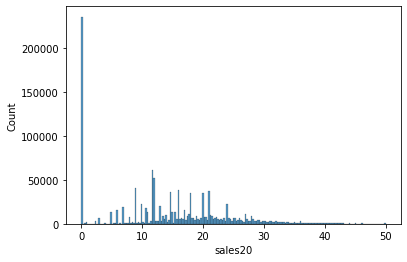

In [15]:
sns.histplot(data=services.loc[services['sales20']<50] , x="sales20") # most are under 50.

In [16]:
# new column - count all services a customer has
services['service_count'] = (services['tv_c']+services['bb_c']+services['iptv_c']
                             +services['dth_c']+services['fttx_c']+services['adsl_c']
                             +services['mobix_c']+services['vdsl_c']+services['voice_c']
                             +services['data_c']+services['fixed_voice_c']+services['prepaid_c'])

In [17]:
services[['service_count', 'combination','customer_age', 'sales20', 'all_sales', 'sales_percentage']].corr() #services.corr()
#services.corr()

,service_count,combination,customer_age,sales20,all_sales,sales_percentage
service_count,1.000000,0.389203,-0.023332,0.110755,0.584491,-0.269543
combination,0.389203,1.000000,0.067909,0.086030,0.324893,-0.146390
customer_age,-0.023332,0.067909,1.000000,-0.156709,-0.105546,-0.065846
sales20,0.110755,0.086030,-0.156709,1.000000,0.492826,0.531882
all_sales,0.584491,0.324893,-0.105546,0.492826,1.000000,-0.161637
sales_percentage,-0.269543,-0.146390,-0.065846,0.531882,-0.161637,1.000000


In [18]:
services[['customer_age','sales20', 'all_sales', 'sales_percentage']].describe()

,customer_age,sales20,all_sales,sales_percentage
count,1.224901e+06,1.224901e+06,1.224901e+06,1.224901e+06
mean,4.982046e+01,1.488824e+01,3.657945e+01,4.578580e-01
std,1.437562e+01,1.184467e+01,3.176562e+01,3.622469e-01
min,1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.900000e+01,7.980000e+00,1.642000e+01,1.668727e-01
50%,4.900000e+01,1.480000e+01,3.002000e+01,3.915362e-01
75%,6.000000e+01,2.099000e+01,5.058000e+01,7.736626e-01
max,2.510000e+02,2.397300e+02,2.402100e+03,1.000000e+00


In [19]:
# change all over 100 to 100 because if their old, it won't make much difference, but it might break model.
services.loc[(services.customer_age >100),'customer_age']= 100

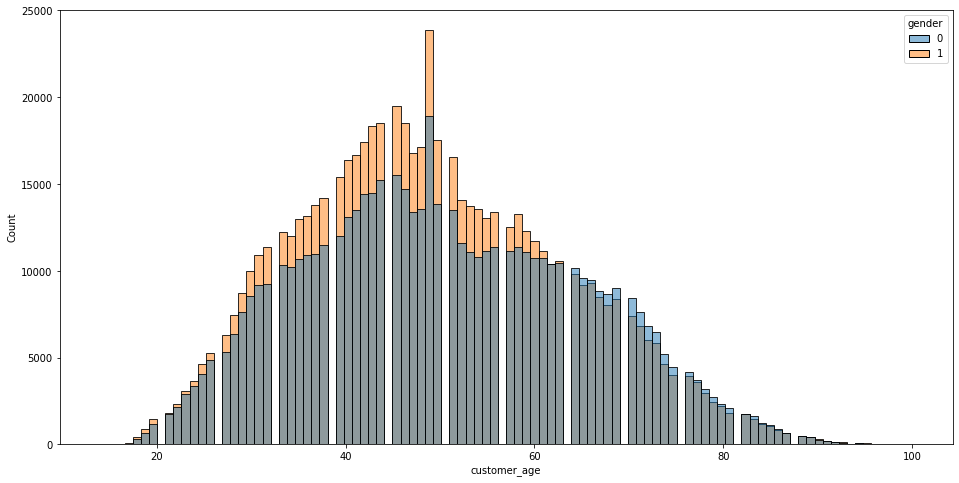

In [20]:
plt.figure(figsize=(16,8)) # much more male customers; normal distribution
sns.histplot(x ='customer_age', data = services, hue='gender', bins = 100)

In [21]:
#sns.pairplot(services ,vars = ['sales20', 'customer_age', 'all_sales'], hue='gender')

### Train-test split and data scaling

In [22]:
services = services.drop(['account_id','cust_id'], axis=1) #, 'sales21'

# # safe personal information to match after prediction
# train_acc_id = np.array(train.pop('account_id')) 
# train_cust_id = np.array(train.pop('cust_id')) 
# test_acc_id = np.array(test.pop('account_id')) 
# test_cust_id = np.array(test.pop('cust_id')) 

# # safe personal information to match after prediction
# train_acc_id = np.array(train.pop('account_id')) 
# train_cust_id = np.array(train.pop('cust_id')) 
# test_acc_id = np.array(test.pop('account_id')) 
# test_cust_id = np.array(test.pop('cust_id')) 


# fix this later!!!!

In [23]:
services.columns

Index(['customer_age', 'subscription_prepaid', 'm_voice', 'm_data', 'adsl',
       'dth', 'fttx', 'iptv', 'mobix', 'vdsl', 'tv_c', 'bb_c', 'iptv_c',
       'dth_c', 'fttx_c', 'adsl_c', 'mobix_c', 'vdsl_c', 'voice_c', 'data_c',
       'fixed_voice_c', 'prepaid_c', 'sales20', 'combination', 'gender',
       'delta', 'all_sales', 'sales_percentage',
       'overusing_voice_overusing_data', 'overusing_voice_right_data',
       'overusing_voice_underusing_data', 'right_voice_overusing_data',
       'right_voice_right_data', 'right_voice_underusing_data',
       'underusing_voice_overusing_data', 'underusing_voice_right_data',
       'underusing_voice_underusing_data', 'service_count'],
      dtype='object')

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [25]:
# drop labels from df and put into array
labels = np.array(services.pop('delta')) 

In [26]:
scaler = MinMaxScaler()
services_scaled = scaler.fit_transform(services)

In [27]:
# unscaled
train, test, train_labels, test_labels = train_test_split(services, labels, test_size=0.25, random_state=50)

In [28]:
# scaled
train_scaled, test_scaled, train_labels_scaled, test_labels_scaled = train_test_split(services_scaled, labels, test_size=0.25, random_state=50)

### Recursive Feature Elimination

In [29]:
# explore the number of selected features for RFE
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [ ]:
# # get a list of models to evaluate
# def get_models():
# 	models = dict()
# 	for i in range(4, 25):
# 		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
# 		model = DecisionTreeClassifier()
# 		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
#   return models
 
# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
# 	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# 	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#   return scores

  # get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(12, 39):
		rfe = RFE(estimator=LogisticRegression(max_iter=2000), n_features_to_select=i)
		model = LogisticRegression(max_iter=2000)
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models


 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
  clf = model.fit(X, y)
  y_pred = clf.predict(test_scaled)
  scores = metrics.accuracy_score(test_labels, y_pred)
  return scores


# define dataset
X = train_scaled[:200000]
y = train_labels[:200000]
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, scores, scores))
# plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

>12 0.777 (0.777)
>13 0.778 (0.778)
>14 0.778 (0.778)


In [ ]:
#clf = DecisionTreeClassifier()
# clf=LogisticRegression(max_iter=2000)

rfe = RFECV(estimator=RandomForestClassifier())
#rfe = RFE(estimator=clf,  step=1,n_features_to_select=10) # n_features_to_select=20,
rfe.fit(train_scaled, train_labels_scaled)

In [ ]:
for i in range(train.shape[1]):
  print(f'Col {i} : " {train.columns[i]} ", selected: {rfe.support_[i]}, Rank: {rfe.ranking_[i]} ')

### Decision Tree

In [ ]:
train

In [ ]:
# IMPORT
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=11, criterion = 'entropy') #(criterion = 'entropy', max_depth=16) 

# Train Decision Tree Classifer
clf = clf.fit(train, train_labels)

In [ ]:
#Predict the response for test dataset
y_pred = clf.predict(test)
y_pred_prob = clf.predict_proba(test)

#### Validation

accuracy, n-fold cross-validation, 

grid- search optimization ? https://stackoverflow.com/questions/63046906/how-to-best-determine-the-accuracy-of-a-model-repeated-train-test-splits-or-cv

In [ ]:
y_pred_train = clf.predict(train)
accuracy = metrics.accuracy_score(train_labels, y_pred_train)
print('Train Accuracy: %f' % accuracy)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

In [ ]:
# plt.figure(figsize=(25,10))
# plot_tree(clf, filled=True,  rounded=True, fontsize=9, feature_names=list(train.columns), class_names= True);

### XGBoost

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# fit model no training data
XGB_model = XGBClassifier()
XGB_model.fit(train, train_labels)

In [ ]:
# make predictions for test data
y_pred = XGB_model.predict(test)
predictions = [round(value) for value in y_pred]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

### Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier( n_estimators = 50, max_features = 5, max_depth= 12 ) # more depth, 

In [69]:
model = model.fit(train, train_labels)

In [70]:
#Predict the response for test dataset
y_pred = model.predict(test)

y_pred_prob = model.predict_proba(test)

In [71]:
y_pred_train = model.predict(train)
accuracy = metrics.accuracy_score(train_labels, y_pred_train)
print('Train Accuracy: %f' % accuracy)

Train Accuracy: 0.793773


In [72]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

Accuracy: 0.791687
Precision: 0.748264
Recall: 0.931802
F1 score: 0.830008
ROC AUC: 0.777565
[[ 86701  52393]
 [ 11398 155734]]


In [ ]:
 feature_list = list(train.columns)
importances = list(model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('{:} Importance: {}'.format(*pair)) for pair in feature_importances]

In [95]:
trees = {'Number_of_trees': [25,50,100,200, 300, 25,50,100,200,300,50,50,50,50,50,50,50,50],
        'Values': [0.966447,0.968584,0.968951,0.968969,0.968969, 0.770552,	0.772802,	0.7737,	0.774967,	0.77534,  0.793773,0.791687,0.79595, 0.793897,0.797176, 0.794743,0.79739, 0.794825],
        'Condition': ['Train', 'Train', 'Train', 'Train', 'Train','Test', 'Test', 'Test', 'Test', 'Test', 'Train', 'Test', 'Train', 'Test','Train', 'Test','Train', 'Test' ],
        'max_features': [0,0,0,0,0,0,0,0,0,0, 5,5,10,10,15,15,20,20 ]}

tree_number_boost = pd.DataFrame(trees, columns = ['Number_of_trees', 'Values', 'Condition', 'max_features'])

In [96]:
tree_number_boost

,Number_of_trees,Values,Condition,max_features
0,25,0.966447,Train,0
1,50,0.968584,Train,0
2,100,0.968951,Train,0
3,200,0.968969,Train,0
4,300,0.968969,Train,0
5,25,0.770552,Test,0
6,50,0.772802,Test,0
7,100,0.773700,Test,0
8,200,0.774967,Test,0
9,300,0.775340,Test,0


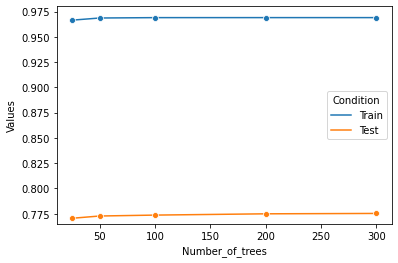

In [113]:
g1 = sns.lineplot(data=tree_number_boost[:10],x="Number_of_trees", y='Values', hue = 'Condition', marker="o")
g1.set(ylim=(0.765, 0.98));

In [ ]:
# after this goes how much max depth improves and that number of trees dont do much even after a good depth. Depth not tested becaus its done in tree? or is same as for tree after testoing

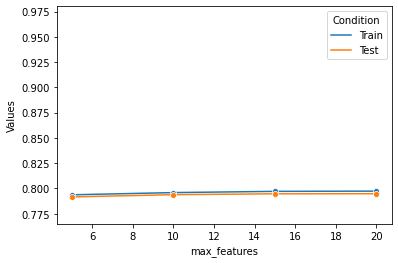

In [114]:
g2 = sns.lineplot(data=tree_number_boost[10:] ,x="max_features", y='Values', hue = 'Condition', marker="o" )
g2.set(ylim=(0.765, 0.98));

### Support Vector Machine

In [ ]:
train_PCA = train[['sales20',
 'customer_age',
 'all_sales',
 'sales_percentage'
#  'subscription_postpaid',
#  'voice_c',
#  'subscription_prepaid',
#  'consumption',
#  'm_voice',
#  'adsl',
#  'prepaid_c',
#  'male',
#  'female'
 ]]

In [ ]:
train_PCA = train_PCA.iloc[:10000]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
# transform data
train_PCA = scaler.fit_transform(train_PCA)

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC()
#model1 = SVC(decision_function_shape='ovo')

In [ ]:
train_labels = train_labels[:10000]

In [ ]:
model.fit(train_PCA, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
test = test[['sales20',
 'customer_age',
 'all_sales',
 'sales_percentage']]

In [ ]:

test = scaler.fit_transform(test)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(test)


In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.7261442176870748


### Logistic Regression

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [ ]:
# define the model
model = LogisticRegression(max_iter=1000)
# fit the model
model.fit(train_scaled, train_labels_scaled);

In [ ]:
y_pred = model.predict(test_scaled)
#y_pred_prob = model.predict_proba(test_scaled)

#### Validation

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels_scaled, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels_scaled, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels_scaled, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels_scaled, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels_scaled, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels_scaled, y_pred)
print(matrix)

Accuracy: 0.778987
Precision: 0.738117
Recall: 0.922271
F1 score: 0.819982
ROC AUC: 0.764545
[[ 84405  54689]
 [ 12991 154141]]


### Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# #Simple network 1
# #Appropriate architecture for the challenge

model = Sequential()
model.add(Dense(16, input_dim=39, activation='relu')) 
model.add(Dropout(0.4))
model.add(Dense(1)) 
model.add(Activation('sigmoid')) 
model.compile(loss='binary_crossentropy',
              optimizer='adam',             #also try adam
              metrics=['accuracy'])

#model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                640       
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# # # Over-Complex network
# # # More complex than needed 

model = Sequential()
model.add(Dense(512, input_dim=38, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1)) 
model.add(Activation('sigmoid'))
opt = Adam(lr=3e-4) 

model.compile(loss='binary_crossentropy',
              optimizer=opt,             #also try adam
              metrics=['accuracy'])

#model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())


In [ ]:
#loss = model.fit(train_scaled, train_labels, epochs=20, batch_size=64, validation_split=0.2)

In [ ]:
#Fit with no early stopping or other callbacks
history = model.fit(train_scaled, train_labels_scaled ,epochs=20, validation_split=0.2) # batch_size=64,
                    #validation_data=(X_test, y_test))


Epoch 1/20
22967/22967 [==============================] - 39s 2ms/step - loss: 0.5240 - accuracy: 0.7576 - val_loss: 0.4806 - val_accuracy: 0.7881
Epoch 2/20
22967/22967 [==============================] - 37s 2ms/step - loss: 0.4905 - accuracy: 0.7809 - val_loss: 0.4785 - val_accuracy: 0.7809
Epoch 3/20
22967/22967 [==============================] - 37s 2ms/step - loss: 0.4881 - accuracy: 0.7822 - val_loss: 0.4775 - val_accuracy: 0.7875
Epoch 4/20
22967/22967 [==============================] - 38s 2ms/step - loss: 0.4871 - accuracy: 0.7830 - val_loss: 0.4778 - val_accuracy: 0.7902
Epoch 5/20
22967/22967 [==============================] - 37s 2ms/step - loss: 0.4843 - accuracy: 0.7851 - val_loss: 0.4775 - val_accuracy: 0.7876
Epoch 6/20
22967/22967 [==============================] - 37s 2ms/step - loss: 0.4859 - accuracy: 0.7844 - val_loss: 0.4760 - val_accuracy: 0.7904
Epoch 7/20
22967/22967 [==============================] - 37s 2ms/step - loss: 0.4847 - accuracy: 0.7856 - val_loss: 0

In [ ]:
loss_, acc = model.evaluate(test_scaled, test_labels_scaled)
print("Accuracy = ", (acc), "%")
print("Loss = ", (loss_), "%")
# Accuracy =  79.47400212287903 % bbz kada cia taip paejo

9570/9570 [==============================] - 10s 1ms/step - loss: 0.4722 - accuracy: 0.7909
Accuracy =  0.7908668518066406 %
Loss =  0.47222068905830383 %


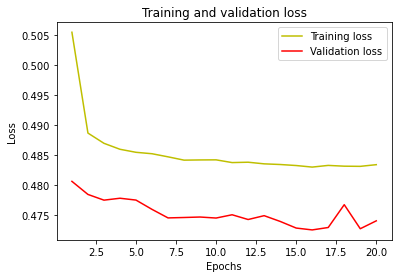

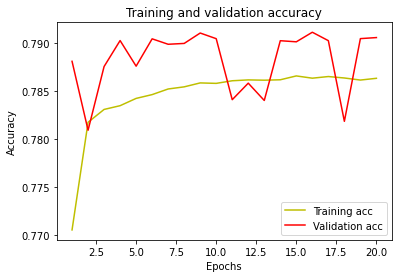

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predicting the Test set results
y_pred = model.predict(test_scaled)
y_pred = (y_pred > 0.50)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(test_labels_scaled, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(test_labels_scaled, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = metrics.recall_score(test_labels_scaled, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(test_labels_scaled, y_pred)
print('F1 score: %f' % f1)

# ROC AUC
auc = metrics.roc_auc_score(test_labels_scaled, y_pred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels_scaled, y_pred)
print(matrix)

Accuracy: 0.790867
Precision: 0.749569
Recall: 0.926292
F1 score: 0.828613
ROC AUC: 0.777218
[[ 87371  51723]
 [ 12319 154813]]


In [ ]:
#sns.heatmap(matrix, annot=True)

In [ ]:
# also draw ROC to look at thresholds! that maybe change results!